# ENV Setup

In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=32
EPOCHS=10

# Data Preprocessing

In [2]:
df=pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')

In [ ]:
df.head()

data : 


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4
...,...,...,...,...,...
95629,rqcsjlsmiz.mp4,129,129,FAKE,pbsccacgff.mp4
95630,xjmnerypjf.mp4,90,90,FAKE,qrjydgidga.mp4
95631,hnewpzhihy.mp4,75,75,FAKE,vabhbfiifl.mp4
95632,okbarlnmwm.mp4,268,267,FAKE,uqaaspbgtz.mp4


In [ ]:
def classify_features(df):
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].nunique() < 10:
                categorical_features.append(column)
            else:
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else:
                continuous_features.append(column)

    return categorical_features, non_categorical_features, discrete_features, continuous_features

In [ ]:
categorical, non_categorical, discrete, continuous = classify_features(df)
print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

In [ ]:
df.isna().sum()

In [8]:
df = df.fillna("Not Available")

In [9]:
for i in categorical:
    print(i,':', df[i].unique())
    print()
for i in categorical:
    print(df[i].value_counts())
    print()

label : ['FAKE' 'REAL']

FAKE    79341
REAL    16293
Name: label, dtype: int64



## Data visualizing

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

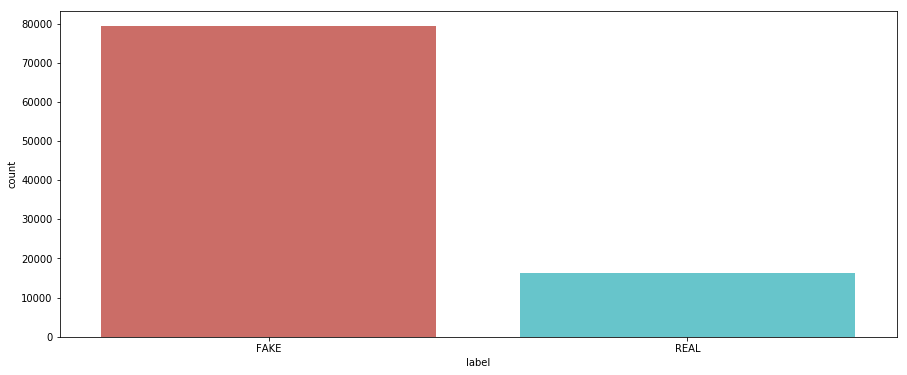

In [11]:
for i in categorical:
    plt.figure(figsize=(15,6))
    sns.countplot(x = df[i], data = df, palette = 'hls')
    plt.show()

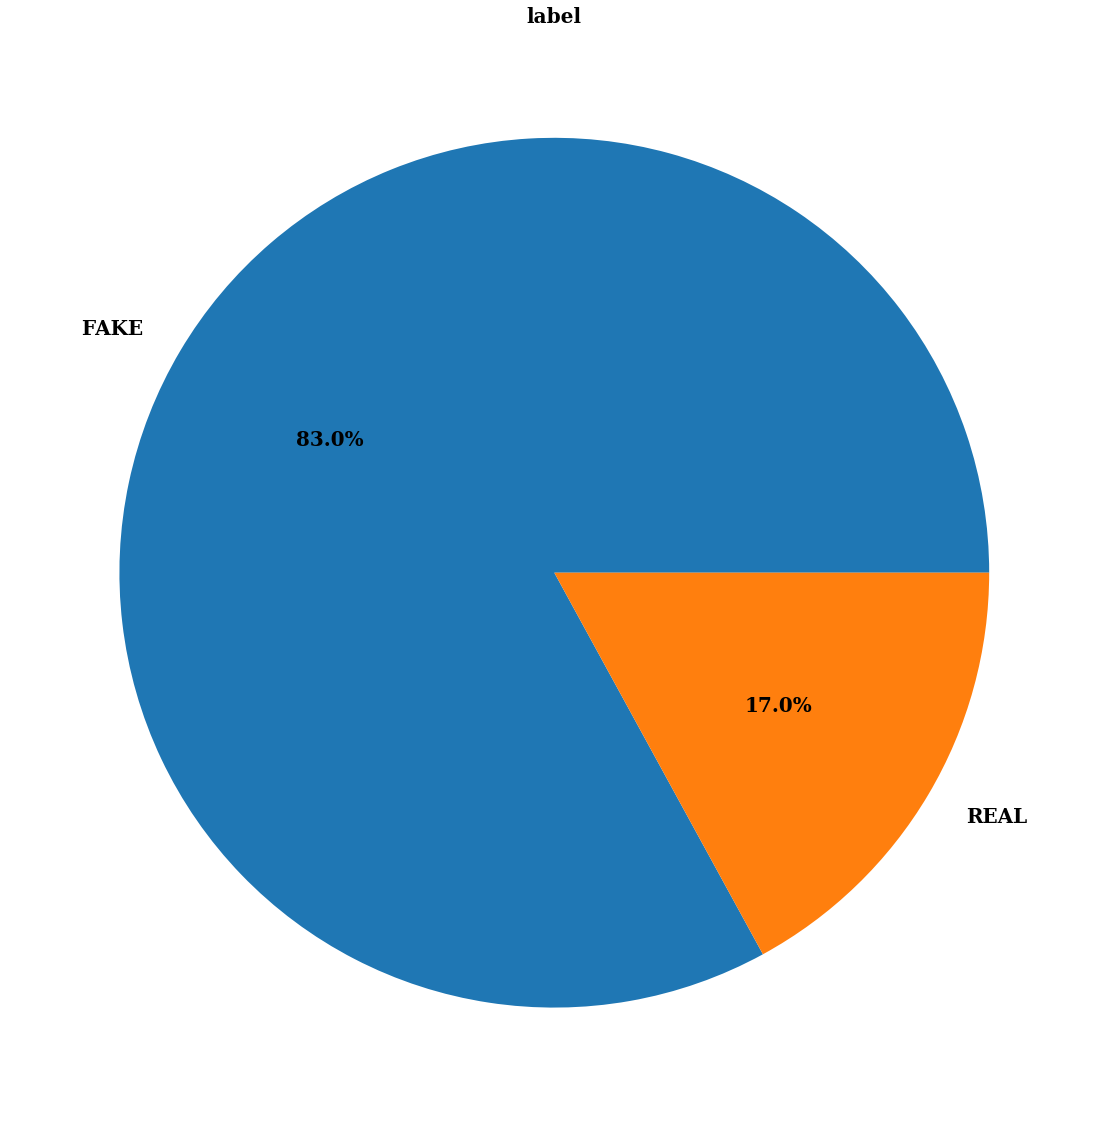

In [12]:
for i in categorical:
    plt.figure(figsize=(30,20)) 
    plt.pie(df[i].value_counts(), labels=df[i].value_counts().index, 
            autopct='%1.1f%%', textprops={ 'fontsize': 20,
                                           'color': 'black',
                                           'weight': 'bold',
                                           'family': 'serif' }) 
    hfont = {'fontname':'serif', 'weight': 'bold'}
    plt.title(i, size=20, **hfont) 
    plt.show()

## Data balancing

In [20]:
real_df = df[df["label"] == "REAL"]
fake_df = df[df["label"] == "FAKE"]
sample_size = 10000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [21]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])
Train_set.shape,Val_set.shape,Test_set.shape

((11200, 5), (4800, 5), (4000, 5))

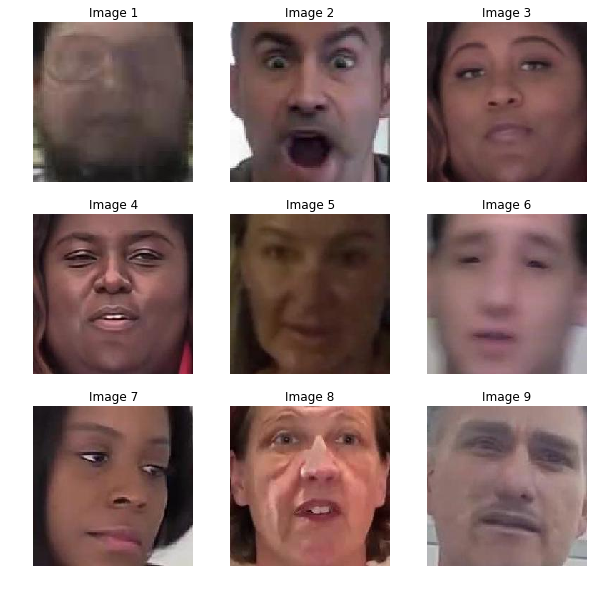

In [22]:
import cv2

image_path = '/kaggle/input/deepfake-faces/faces_224/'

image_files = os.listdir(image_path)

image_files.sort()

selected_images = image_files[:9]

plt.figure(figsize=(10, 10))

for index, image_file in enumerate(selected_images):
    image = cv2.imread(os.path.join(image_path, image_file))

    plt.subplot(3, 3, index + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {index + 1}')
    plt.axis('off')

plt.show()

In [25]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [26]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

# Modeling

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from functools import partial

tf.random.set_seed(42)

In [ ]:
# Save the best model based on validation loss
def get_callbacks(name):
    checkpoint_cb = ModelCheckpoint(
        filepath=f'best_model_{name}.h5',          # or 'best_model.keras' for TF 2.12+
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Stop training early if validation loss doesn't improve
    earlystop_cb = EarlyStopping(
        monitor='val_loss',
        patience=3,       # Number of epochs with no improvement
        restore_best_weights=True,
        verbose=1
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Combine all callbacks
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

    return callbacks

## Custom Model

In [ ]:
DefaultConv2D = partial(layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

# Model Definition
model = models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu",
                 kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation="relu",
                 kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=1, activation="sigmoid")
])

In [29]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 128)       5

In [ ]:
history = model.fit(
    X_train, 
    y_train,
    epochs=10,
    callbacks=get_callbacks('custom'),
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    verbose=1
)

Train on 11200 samples, validate on 4800 samples
Epoch 1/10
11200/11200 [==============================] - 69s 6ms/sample - loss: 0.8268 - accuracy: 0.5213 - val_loss: 0.8274 - val_accuracy: 0.5002
Epoch 2/10
11200/11200 [==============================] - 65s 6ms/sample - loss: 0.7010 - accuracy: 0.5658 - val_loss: 0.6583 - val_accuracy: 0.6060
Epoch 3/10
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.6658 - accuracy: 0.5977 - val_loss: 0.6411 - val_accuracy: 0.6265
Epoch 4/10
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.6467 - accuracy: 0.6233 - val_loss: 0.6851 - val_accuracy: 0.5733
Epoch 5/10
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.6201 - accuracy: 0.6516 - val_loss: 0.6250 - val_accuracy: 0.6352
Epoch 6/10
11200/11200 [==============================] - 66s 6ms/sample - loss: 0.6021 - accuracy: 0.6720 - val_loss: 0.6516 - val_accuracy: 0.6131
Epoch 7/10
11200/11200 [==============================] -

### Model Evolution

In [33]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

In [34]:
y_test_pred_binary = (y_pred > 0.5).astype(int)

In [35]:
y_train_pred = model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 88.54%


In [37]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 66.35%


In [38]:
f1 = f1_score(y_test, y_test_pred_binary)
print(f"F1 Score: {f1:.4f}")

precision = precision_score(y_test, y_test_pred_binary)
print(f"Precison: {precision:.4f}")

recall = recall_score(y_test, y_test_pred_binary)
print(f"Recall: {recall:.4f}")

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_test_pred_binary)
print(f"AUC-ROC: {auc_roc:.4f}")

F1 Score: 0.6821
Precison: 0.6464
Recall: 0.7220
AUC-ROC: 0.6635


In [39]:
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1210  790]
 [ 556 1444]]


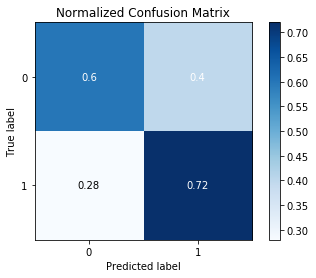

In [40]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_binary, normalize=True)
plt.show()

In [41]:
class_report = classification_report(y_test, y_test_pred_binary)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2000
           1       0.65      0.72      0.68      2000

    accuracy                           0.66      4000
   macro avg       0.67      0.66      0.66      4000
weighted avg       0.67      0.66      0.66      4000



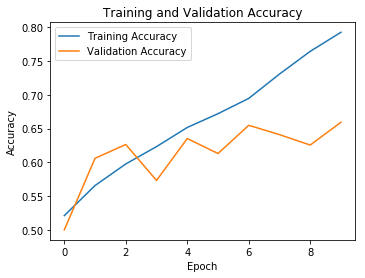

In [ ]:
import matplotlib.pyplot as plt

# Unpack training history
hist = history.history

# Create 2x2 subplot
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(hist['precision'], label='Train Precision')
plt.plot(hist['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(hist['recall'], label='Train Recall')
plt.plot(hist['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


## Training With Pre train model

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in base_model.layers:
    layer.trainable = False
    
model_resnet50 = models.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(layers.GlobalAveragePooling2D())
model_resnet50.add(layers.Dense(1, activation='sigmoid'))

94773248/94765736 [==============================] - 0s 0us/step


In [45]:
model_resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [46]:
from tensorflow.keras import optimizers

model_resnet50.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
history = model_resnet50.fit(
    X_train, y_train,
    epochs=10,  
    validation_data=(X_val, y_val),
    verbose=1
)

Train on 11200 samples, validate on 4800 samples
Epoch 1/10
11200/11200 [==============================] - 61s 5ms/sample - loss: 0.6679 - accuracy: 0.6010 - val_loss: 0.7305 - val_accuracy: 0.5767
Epoch 2/10
11200/11200 [==============================] - 56s 5ms/sample - loss: 0.6083 - accuracy: 0.6729 - val_loss: 0.8553 - val_accuracy: 0.5490
Epoch 3/10
11200/11200 [==============================] - 56s 5ms/sample - loss: 0.5995 - accuracy: 0.6764 - val_loss: 0.8148 - val_accuracy: 0.5590
Epoch 4/10
11200/11200 [==============================] - 56s 5ms/sample - loss: 0.5735 - accuracy: 0.6963 - val_loss: 0.8271 - val_accuracy: 0.5579
Epoch 5/10
11200/11200 [==============================] - 56s 5ms/sample - loss: 0.5661 - accuracy: 0.7041 - val_loss: 0.7069 - val_accuracy: 0.6085
Epoch 6/10
11200/11200 [==============================] - 56s 5ms/sample - loss: 0.5616 - accuracy: 0.7142 - val_loss: 0.8264 - val_accuracy: 0.5633
Epoch 7/10
11200/11200 [==============================] -

### Model Evolution

In [48]:
y_pred = model_resnet50.predict(X_test)

In [49]:
y_test_pred_binary = (y_pred > 0.5).astype(int)

In [50]:
y_train_pred = model_resnet50.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

In [51]:
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 57.36%


In [52]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 56.60%


In [53]:
f1 = f1_score(y_test, y_test_pred_binary)
print(f"F1 Score: {f1:.4f}")

precision = precision_score(y_test, y_test_pred_binary)
print(f"Precison: {precision:.4f}")

recall = recall_score(y_test, y_test_pred_binary)
print(f"Recall: {recall:.4f}")

F1 Score: 0.6580
Precison: 0.5429
Recall: 0.8350


In [54]:
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 594 1406]
 [ 330 1670]]


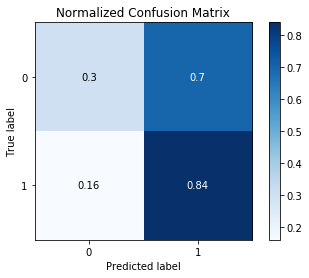

In [55]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_binary, normalize=True)
plt.show()

In [56]:
class_report = classification_report(y_test, y_test_pred_binary)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.30      0.41      2000
           1       0.54      0.83      0.66      2000

    accuracy                           0.57      4000
   macro avg       0.59      0.57      0.53      4000
weighted avg       0.59      0.57      0.53      4000



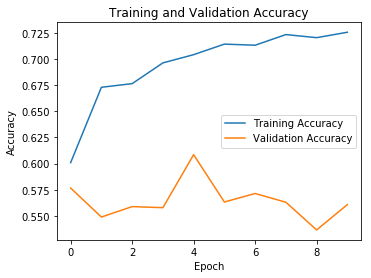

In [ ]:
import matplotlib.pyplot as plt

# Unpack training history
hist = history.history

# Create 2x2 subplot
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(hist['precision'], label='Train Precision')
plt.plot(hist['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(hist['recall'], label='Train Recall')
plt.plot(hist['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
